In [2]:
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from pathlib import Path
import os
import json

In [3]:
dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)
api_key=os.getenv("deepseekkey")
# api_key=os.getenv("gptAPIKEY")
# print(api_key)

In [4]:
class Agent(TypedDict):
    message : Annotated[Sequence[BaseMessage], add_messages]
    parsed : json

In [ ]:
# filecontents=""
# with open("events.txt",'a+') as file:
#     file.seek(0)
#     filecontents=(file.read())
# filecontents

'\n'

In [6]:
@tool
def saveevent(content:str)->str:
    """save the contents to a text file """
    with open("events.txt",'a+') as file:
        file.write(content)
    return "contents has been sucessfully been saved in events.txt"
@tool
def savecontent(content:str)->str:
    """save the contents to a text file """
    with open("contents.txt",'w+') as file:
        file.write(content)
    return "contents has been sucessfully been saved in events.txt"

@tool
def date():
    "returns today's date"
    from datetime import date
    return date.today()

tools = [saveevent,savecontent,date] 

In [7]:
# model= ChatOpenAI(model="z-ai/glm-4.5-air:free",api_key=api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools)

model= ChatOpenAI(model="deepseek/deepseek-chat-v3-0324:free",api_key=api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools=tools)

In [18]:
def process(state: Agent) -> Agent:
    'enter the task/date'
    system_prompt = SystemMessage(content=f"""
    You are a scheduling assistant.
    You can use the 'date' tool for reference                               
    Output ONLY in JSON format:
    {{
        "event": "...",
        "date-time": "D/M-H:M",
        "priority": "high|medium|low"
    }}
    the contents of this conversation are {filecontents}    
    """)
    
    user_input = state['message']
    final_messages = [system_prompt, user_input]
    
    response = model.invoke(final_messages)  # no `input=...`
    
    print("Full Response:", )
    if isinstance(response, AIMessage):
        print("AI says:", response.content)
        return {"message": [response]}
    else:
        print("Unexpected response type:", type(response))
        return {"message": []}

    
def printmessage(state:Agent)->Agent:
    'converts to json'
    val=state['message']
    val=val[1].content
    val=val.replace(' ','')
    val=val.replace('\n','')
    val=val.replace('n\'s',"n ")
    val=val.replace("json","")
    state['parsed']=json.loads(val)
    print("k",state['parsed'])
    return state

def savecontent(state:Agent)->Agent:
    'saves the content'
    val=state['parsed']
    with open("events.txt",'a+') as file:
        flag=0
        for i in file:
            i=json.loads(i.strip())
            if i['date-time']==val['date-time'] and i['event']==val['event']:
                print("fuck")
                flag=1
                break
        if flag==0:
                file.seek(0,os.SEEK_END)
                file.write(json.dumps(val) + "\n")
    state['message']=[]
    state['parsed']={}
    return state

def shouldcontinue(state:Agent):
    user_input=""
    'Determine if we should continue or end the conversation'
    user_input = HumanMessage(content=input("Enter your task: "))
    print(user_input)
    state['message']=user_input
    if user_input.content == "end":
        return "end"
    else:    
        return "continue"

In [19]:
graph=StateGraph(Agent)
graph.add_node("user",process)
graph.add_node("printmessage",printmessage)
graph.add_node("save",savecontent)
graph.add_node("dec",lambda state:state)
graph.set_entry_point("dec")
graph.add_conditional_edges("dec",
    shouldcontinue,
    {
        "continue":"user",
        "end":END,
    }                            
)
graph.add_edge("user","printmessage")
graph.add_edge("printmessage",'save')
graph.add_edge("save","dec")
app=graph.compile()

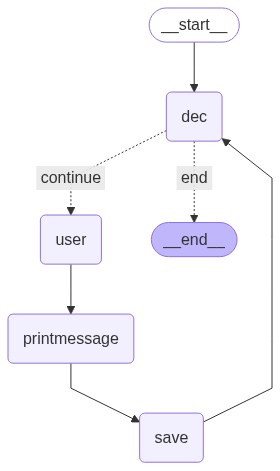

In [20]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
res=app.invoke({'message':'','parsed':''})
print('f',res)

content='end' additional_kwargs={} response_metadata={}
f {'message': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='0469fa94-5e3d-4e7a-a901-a2050666605c')], 'parsed': ''}


In [17]:
a=HumanMessage(content=input("Enter your task: "))
print(a)

content='hi' additional_kwargs={} response_metadata={}
